# 7 【案例2】目标识别

## 7.1 下载模型

In [35]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests
import torch
import util.quant_tool

# 使用facebook/detr-resnet-50模型进行实验
# 视频课程请移至 https://learn.deeplearning.ai/courses/quantization-in-depth
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

In [36]:
# 量化前模型大小
previous_memory_footprint = model.get_memory_footprint()
print("Footprint of the model in MBs: ", 
      previous_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


## 7.2 加载图片

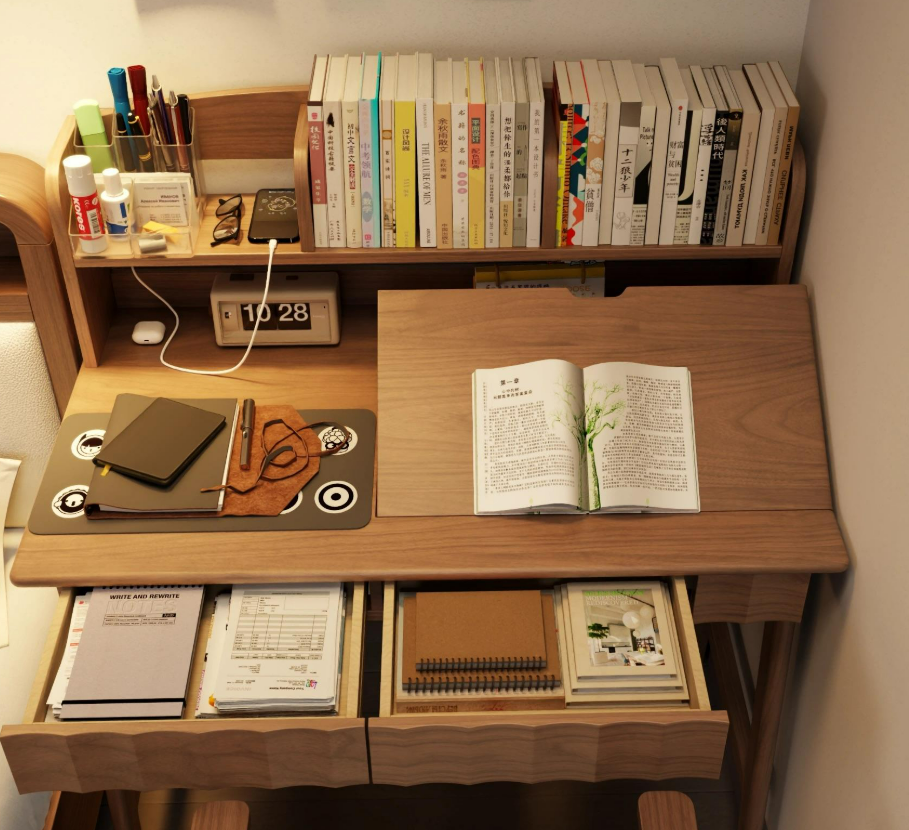

In [37]:
img_path = "./img/image.png"
image = Image.open(img_path).convert("RGB")
image

In [38]:
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

# 只保留输出分数大于0.9的目标
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

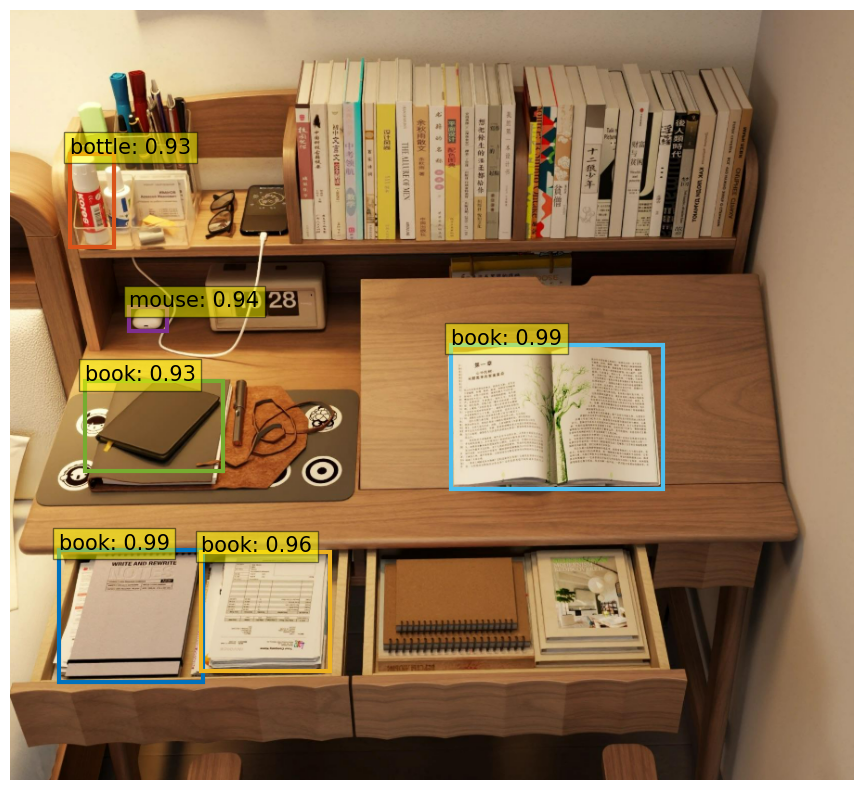

In [39]:
# 展示标记后的图片
import util.quant_tool as quant_tool
quant_tool.plot_results(model, image, results)

In [40]:
# 量化前的模型结构
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

## 7.3 对模型进行对称量化

In [41]:
import copy
# 对模型权重进行对称量化
base_model = copy.deepcopy(model)
q_model = quant_tool.quantize_model_weights(model=base_model,per_channel=False,is_symmetric=True,modules_to_exclude=["0", "1", "2", "class_labels_classifier"])
# 检查量化后的模型结构
q_model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [42]:
# 使用检查后的模型进行目标识别
with torch.no_grad():
  q_outputs = q_model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
q_results = processor.post_process_object_detection(q_outputs, target_sizes=target_sizes, threshold=0.9)[0]

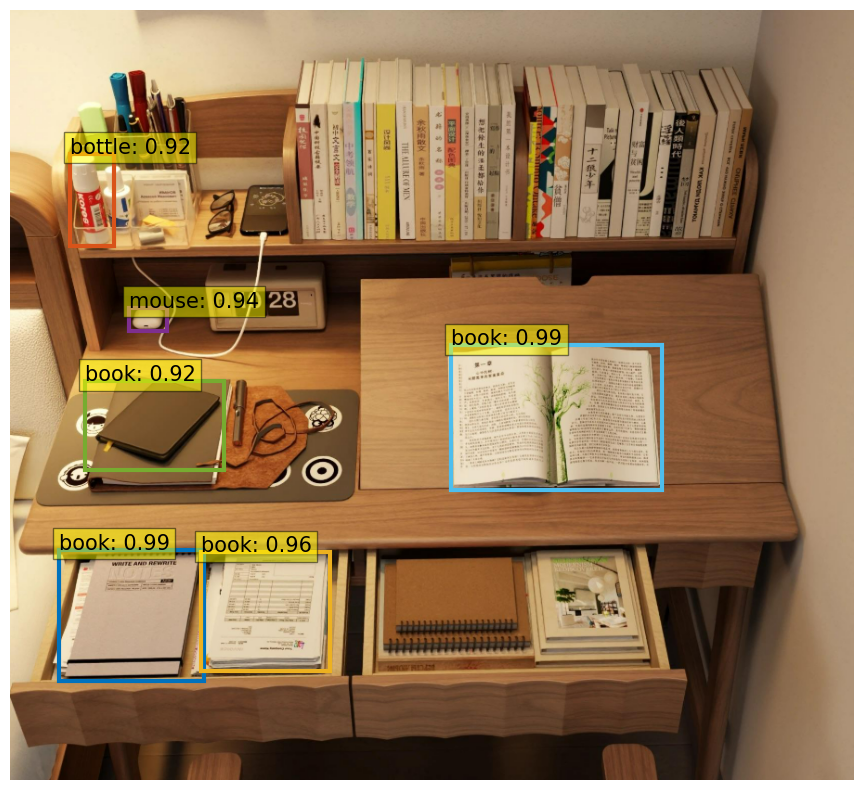

In [43]:
# 展示标记后的图片
import util.quant_tool as quant_tool
quant_tool.plot_results(q_model, image, q_results)

In [44]:
# 量化前模型大小
model_memory = model.get_memory_footprint()
print("量化前模型占用空间 MBs：", 
      model_memory/1e+6)
# 量化后模型大小
q_model_memory = q_model.get_memory_footprint()
print("量化后模型占用空间 MBs：", 
      q_model_memory/1e+6)
# 对比量化前和量化后的模型大小
print("节省空间 MBs: ", 
      (model_memory - q_model_memory)/1e+6)

量化前模型占用空间 MBs： 166.524032
量化后模型占用空间 MBs： 114.620288
节省空间 MBs:  51.903744


### 恭喜你完成了量化的入门实践，敬请期待后续任务及工作~~
### 点个start支持一下作者吧！